In [263]:
import numpy as np
from copy import copy
from multiprocessing import Pool

In [264]:
def naive_mult(a, b):
    
    n_rows = a.shape[0]
    n_cols = b.shape[1]
    res = np.zeros((n_rows, n_cols))
    
    for i in range(n_rows):
        for j in range(n_cols):
            for k in range( a.shape[1] ):
                res[i, j] += a[i, k] * b[k, j]
    
    return res    

class Split:
    def init(self, i=0, j=0, step=0):
        self.i = i
        self.j = j
        self.step = step
    
    def isscalar(self):
        return self.step == 1
        
    def get_start(self):
        return self.i, self.j

    def to_str(self):
        return f"{self.i, self.j}, {self.step}"
    
    def fetch_matrix(self, m):
        return m[ self.i : self.i+self.step, self.j : self.j+self.step ]
    
def split_matrix(split):
    step = split.step // 2
    
    top_left = Split()
    top_left.i = split.i
    top_left.j = split.j
    top_left.step = step

    top_right = Split()
    top_right.i = split.i
    top_right.j = split.j + step
    top_right.step = step
    
    bottom_left = Split()
    bottom_left.i = split.i + step
    bottom_left.j = split.j
    bottom_left.step = step
    
    bottom_right = Split()
    bottom_right.i = split.i + step
    bottom_right.j = split.j + step
    bottom_right.step = step
    
    return np.array([[top_left, top_right], [bottom_left, bottom_right]])

def recursive_mult(M_1, M_2, A_idx=None, B_idx=None):
    n = min(M_1.shape[0], M_2.shape[0])
    
    if A_idx is None:
        A_idx = Split()
        A_idx.init()
        A_idx.step = n
    
    if B_idx is None:
        B_idx = Split()
        B_idx.init()
        B_idx.step = n
        
    def rMult(A_idx, B_idx):
        if A_idx.isscalar():
            C = np.array([[M_1[A_idx.get_start()] * M_2[B_idx.get_start()]]])
        else:
            new_A_split = split_matrix(A_idx)
            new_B_split = split_matrix(B_idx)

            C_tl = rMult(new_A_split[0, 0], new_B_split[0, 0]) + rMult(new_A_split[0, 1], new_B_split[1, 0])
            C_tr = rMult(new_A_split[0, 0], new_B_split[0, 1]) + rMult(new_A_split[0, 1], new_B_split[1, 1])
            C_bl = rMult(new_A_split[1, 0], new_B_split[0, 0]) + rMult(new_A_split[1, 1], new_B_split[1, 0])
            C_br = rMult(new_A_split[1, 0], new_B_split[0, 1]) + rMult(new_A_split[1, 1], new_B_split[1, 1])

            C = build_matrix([C_tl, C_tr, C_bl, C_br])
        return C

    return rMult(A_idx, B_idx)

   
def build_matrix(submatrices):
    C_tl, C_tr, C_bl, C_br = submatrices
    n = C_tl.shape[0]
    new_n = n*2

    new_C = np.zeros( (new_n, new_n) )
    for i in range(n):
        for j in range(n):
            new_C[i, j] = C_tl[i, j]
            new_C[i, j + n] = C_tr[i, j]
            new_C[i + n, j] = C_bl[i, j]
            new_C[i + n, j + n] = C_br[i, j]

    return new_C
    
    
def strassen(A, B):

    def add(M, A_split, B_split):
        step = A_split.step

        res = np.zeros( (step, step) )
        for i in range(step):
            for j in range(step):
                res[i, j] = M[A_split.i + i, A_split.j + j] + M[B_split.i + i, B_split.j + j]

        return res

    def substract(M, A_split, B_split):
        step = A_split.step

        res = np.zeros( (step, step) )
        for i in range(step):
            for j in range(step):
                res[i, j] = M[A_split.i + i, A_split.j + j] - M[B_split.i + i, B_split.j + j]

        return res
    
    n = A.shape[0]

    A_s = Split()
    A_s.init()
    A_s.step = n
    
    B_s = Split()
    B_s.init()
    B_s.step = n
    
    A_split = split_matrix(A_s)
    B_split = split_matrix(B_s)
    
    S_1 = substract(copy(B), B_split[0, 1], B_split[1, 1])
    
    S_2 = add(copy(A), A_split[0, 0], A_split[0, 1])
    
    S_3 = add(copy(A), A_split[1, 0], A_split[1, 1])
    
    S_4 = substract(copy(B), B_split[1, 0], B_split[0, 0])
    
    S_5 = add(copy(A), A_split[0, 0], A_split[1, 1])
    
    S_6 = add(copy(B), B_split[0, 0], B_split[1, 1])
    
    S_7 = substract(copy(A), A_split[0, 1], A_split[1, 1])
    
    S_8 = add(copy(B), B_split[1, 0], B_split[1, 1])
    
    S_9 = substract(copy(A), A_split[0, 0], A_split[1, 0])
    
    S_10 = add(copy(B), B_split[0, 0], B_split[0, 1])
    
    # Comment the recursive multiplication to speedup the algorithm
    P_1 = recursive_mult(copy(A), copy(S_1), A_split[0, 0], None)
    P_2 = recursive_mult(copy(S_2), copy(B), None, B_split[1, 1])
    P_3 = recursive_mult(copy(S_3), copy(B), None, B_split[0, 0])
    P_4 = recursive_mult(copy(A), copy(S_4), A_split[1, 1], None)
    P_5 = recursive_mult(copy(S_5), copy(S_6))
    P_6 = recursive_mult(copy(S_7), copy(S_8))
    P_7 = recursive_mult(copy(S_9), copy(S_10))
    
    # Uncomment the following block for naive computation of P matrices
    # to speedup the algoritm
    """
    P_1 = naive_mult( A_split[0, 0].fetch_matrix(A), S_1 )
    P_2 = naive_mult( S_2, B_split[1, 1].fetch_matrix(B) )
    P_3 = naive_mult( S_3, B_split[0, 0].fetch_matrix(B) )
    P_4 = naive_mult( A_split[1, 1].fetch_matrix(A), S_4 )
    P_5 = naive_mult( S_5, S_6 )
    P_6 = naive_mult( S_7, S_8 )
    P_7 = naive_mult( S_9, S_10 )
    """
    
    C_11 = P_5 + P_4 - P_2 + P_6
    C_12 = P_1 + P_2
    C_21 = P_3 + P_4
    C_22 = P_5 + P_1 - P_3 - P_7
    
    C = build_matrix([C_11, C_12, C_21, C_22])
    
    return C
    
    
    
def is_equal(a, b):
    return (abs(strassen_res - naive_res) <= 10e-9).all()

In [265]:
n = 2
A = np.random.rand(n, n)
B = np.random.rand(n, n)

strassen_res = strassen(A, B)
naive_res = naive_mult(A, B)

In [184]:
%timeit -n5 strassen_res = strassen(A, B)

1.63 s ± 9.09 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [185]:
%timeit -n5 naive_res = naive_mult(A, B)

1.59 s ± 123 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [276]:
from time import time
dims = (2**p for p in range(1, 11))

stats_strassen = {"N":[], "t":[]}
stats_naive = {"N":[], "t":[]}
for n in dims:
    A = np.random.rand(n, n)
    B = np.random.rand(n, n)
    t = 0
    for _ in range(10):
        start = time()*1000
        strassen_res = strassen(A, B)
        t += (time()*1000 - start)/5
    stats_strassen['N'].append(n)
    stats_strassen['t'].append(t)
    
    t = 0
    for _ in range(10):
        start = time()*1000
        naive_res = naive_mult(A, B)
        t += (time()*1000 - start)/5
    stats_naive['N'].append(n)
    stats_naive['t'].append(t)
    

KeyboardInterrupt: 

In [284]:
import pandas as pd

stats_naive["N"] = [2**p for p in range(10)]
stats_naive["t"] = [0.02, 0.04, 0.21, 1.53, 6.66, 56.09, 510.94, 4203.01, 24901.37, 203164.7]

stats_strassen["N"] = [2**p for p in range(10)]
stats_strassen["t"] = [0.31, 1.92, 2.21, 2.56, 8.99, 55.78, 423.18, 3999.32, 22416.71, 172872.95]

df_strassen = pd.DataFrame(stats_strassen)
df_naive = pd.DataFrame(stats_naive)

In [285]:
df_strassen

,N,t
0,1,0.31
1,2,1.92
2,4,2.21
3,8,2.56
4,16,8.99
5,32,55.78
6,64,423.18
7,128,3999.32
8,256,22416.71
9,512,172872.95


In [286]:
df_naive

,N,t
0,1,0.02
1,2,0.04
2,4,0.21
3,8,1.53
4,16,6.66
5,32,56.09
6,64,510.94
7,128,4203.01
8,256,24901.37
9,512,203164.70


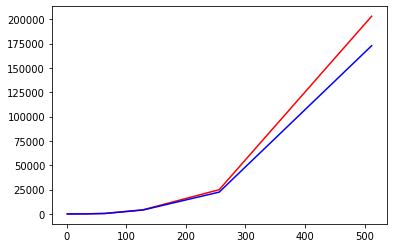

In [287]:
from matplotlib import pyplot as plt

_ = plt.plot(df_naive.N, df_naive.t, color='r')
_ = plt.plot(df_naive.N, df_strassen.t, color='b')

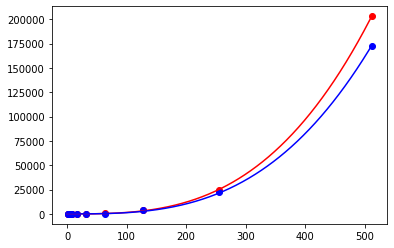

In [289]:
from scipy.optimize import curve_fit

def cubic(x, a):
    return a*x**3

def nlog7(x, a):
    return a * x**np.log(7)


_ = plt.scatter(df_naive.N, df_naive.t, color='r')
_ = plt.scatter(df_naive.N, df_strassen.t, color='b')


popt, pcov = curve_fit(cubic, df_naive.N, df_naive.t)

plt.plot(np.linspace(0, 512, 512), cubic(np.linspace(0, 512, 512), popt[0]), color='r')
# _ = plt.plot(df_naive.N, df_naive.t)



popt, pcov = curve_fit(cubic, df_naive.N, df_strassen.t)

_ = plt.plot(np.linspace(0, 512, 512), cubic(np.linspace(0, 512, 512), popt[0]), color='b')
# _ = plt.plot(df_naive.N, df_strassen.t)

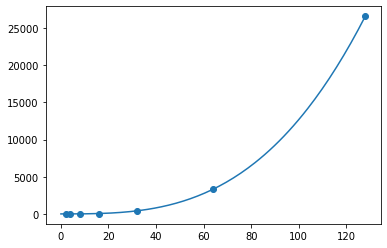

In [282]:
popt, pcov = curve_fit(cubic, df_naive.N, df_strassen.t)

plt.plot(np.linspace(0, 128, 128), cubic(np.linspace(0, 128, 128), popt[0]))
_ = plt.scatter(df_naive.N, df_strassen.t)

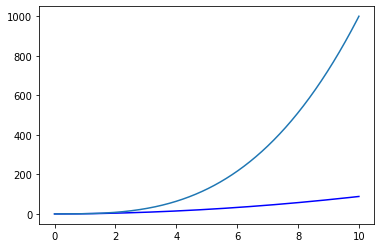

In [283]:
plt.plot(np.linspace(0, 10, 512), nlog7(np.linspace(0, 10, 512), 1), color="b")
_ = plt.plot(np.linspace(0, 10, 512), cubic(np.linspace(0, 10, 512), 1))